In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.decomposition import IncrementalPCA

In [2]:
iris = load_iris()
iris_data = iris.data
iris_target = iris.target
iris_names = iris.target_names

# Information about sklearn datasets iris
<b>iris_data</b> is a numpy.ndarray with N rows and 4 columns.
Each row represents a different instance of a type of Iris flower. The instances are drawn from three types of Irises: Setosa, Versicolour, and Virginica.
The four columns are features of each flower such as sepal length and width and petal length and width.
See:
https://scikitlearn.org/stable/auto_examples/datasets/plot_iris_dataset.html
<br>
<br>
<b>iris_target</b> is a 1D numpy.ndarray. It has N elements where iris_target[j] is the type of Iris for the flower described in iris_data[j]. In this example N is 150.
<br>
<br>
<b>iris_names</b> is a list of the names of the irises.

<b>We first take a random permutation</b> of the data and target because the given data is aranged in order of target.

In [3]:
permutation = np.random.permutation(len(iris_target))
iris_data = np.take(iris_data, permutation, axis=0)
iris_target = np.take(iris_target, permutation)

In [4]:
# Function to plot data
def plot_data(colors, names, data, target):
    plt.figure(figsize=(8, 8))
    N = len(names)
    for color, i, target_name in zip(colors, list(range(N)), names):
        plt.scatter(data[target == i, 0], 
                    data[target == i, 1],
                    color=color, lw=2, label=target_name)
    plt.title("Incremental PCA of iris dataset")
    plt.show()

## Create an incremental PCA object
<b>n_components</b> is the number of components of the transformed data. In this case, with <i>n_components</i> = 2, the 4-dimensional given data is projected onto a 2-dimensional plane.

In [5]:
ipca = IncrementalPCA(n_components=2)
# Colors used in the plot. Each color represents a target.
colors = ['navy', 'turquoise', 'darkorange']
WINDOW_SIZE = 50

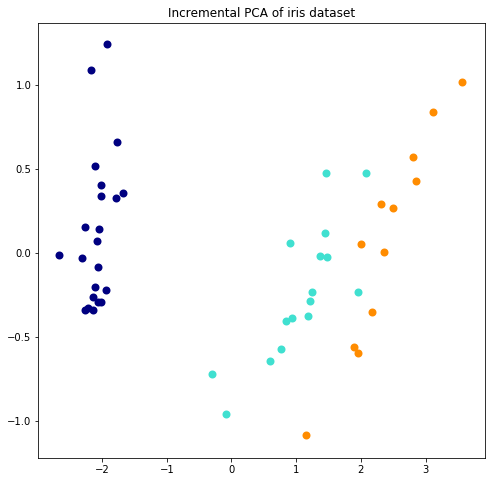

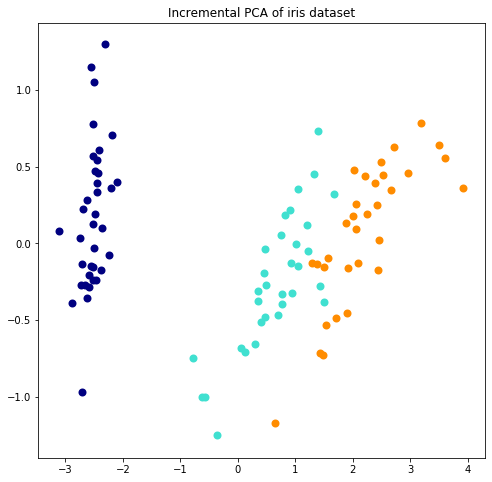

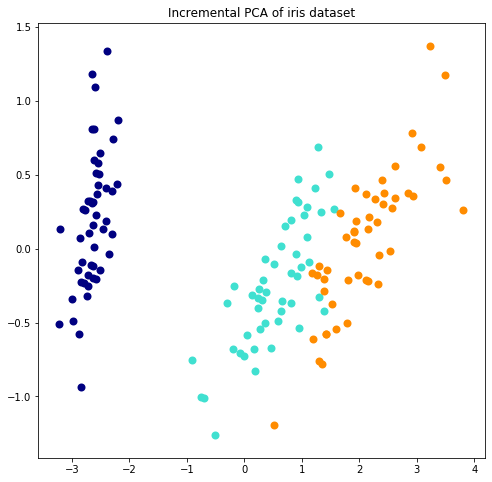

In [6]:
for step_number in range(3):
    data = iris_data[
        WINDOW_SIZE*step_number: WINDOW_SIZE*(step_number+1), :]
    iris_data_principal_components = ipca.partial_fit(data)
    transformed_data = iris_data_principal_components.transform(
        iris_data[:WINDOW_SIZE*(step_number+1)])
    target = iris_target[:WINDOW_SIZE*(step_number+1)]
    plot_data(colors, iris_names, transformed_data, target)

# IoTPy
Use a <b>sliding window</b> to see the effect of incremental data.

In [7]:
import sys
sys.path.append("../")
from IoTPy.core.stream import Stream, StreamArray, run
from IoTPy.agent_types.merge import merge_window, zip_stream
from IoTPy.core.helper_control import _multivalue
from IoTPy.helper_functions.recent_values import recent_values

In [8]:
ipca = IncrementalPCA(n_components=2)
data_stream = StreamArray(name='data_stream', dimension=4, dtype=float)
target_stream = StreamArray(name='target_stream', dtype=int)
transformed_stream = StreamArray(name='transformed_stream', 
                                 dimension=2, dtype=float)

In [9]:
def f(windows, state):
    data, target = windows
    saved_data, saved_target = state
    iris_data_principal_components = ipca.partial_fit(data)
    saved_data = (data if saved_data is None
                  else np.concatenate((saved_data, data), axis=0))
    saved_target = (target if saved_target is None
                    else np.concatenate((saved_target, target), axis=0))
    next_state = saved_data, saved_target
    transformed_data = iris_data_principal_components.transform(
        saved_data)
    output_data = iris_data_principal_components.transform(data)
    plot_data(colors, iris_names, transformed_data, saved_target)
    return _multivalue(output_data), next_state
    

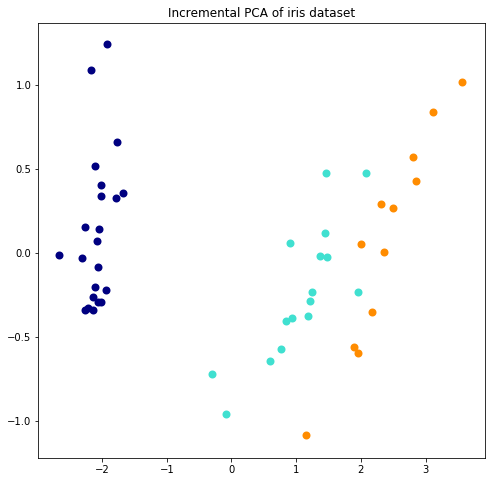

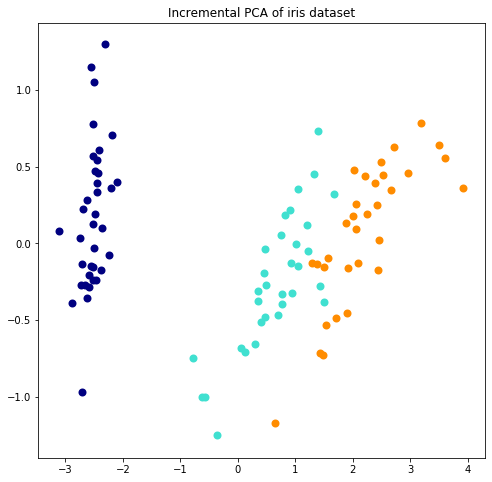

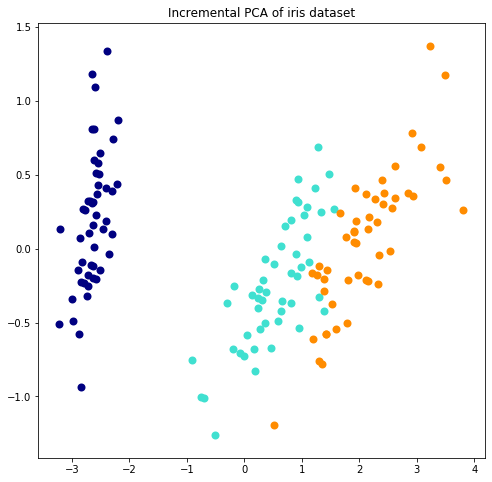

[(array([-2.08047107,  0.06857922]), 0), (array([-1.94191104, -0.21944479]), 0), (array([-2.14011261, -0.34192932]), 0), (array([1.44150423, 0.11612385]), 1), (array([-2.21396812, -0.33091379]), 0), (array([ 1.95115577, -0.59677707]), 2), (array([-1.77457291,  0.66108844]), 0), (array([ 0.846533  , -0.40733029]), 1), (array([ 1.9568268 , -0.23618647]), 1), (array([ 1.4802727 , -0.02323343]), 1), (array([-1.78358831,  0.32797596]), 0), (array([-1.68085916,  0.35318968]), 0), (array([ 2.17752739, -0.35384293]), 2), (array([-2.06047724, -0.29542354]), 0), (array([ 1.15991904, -1.08632566]), 2), (array([-1.92015875,  1.24428961]), 0), (array([-0.30021321, -0.72003509]), 1), (array([-2.05553657, -0.08656235]), 0), (array([ 1.2203177 , -0.28813792]), 1), (array([1.45843815, 0.47461885]), 1), (array([-2.26472985, -0.34119032]), 0), (array([ 1.37383534, -0.01669789]), 1), (array([-2.17132929,  1.08937751]), 0), (array([-0.08201781, -0.96155332]), 1), (array([ 0.59570222, -0.6421916 ]), 1), (ar

In [10]:
merge_window(func=f, in_streams=[data_stream, target_stream],
            out_stream=transformed_stream, state=(None, None),
            window_size=50, step_size=50)
#file_stream = StreamArray(name='file_stream', dimension=3, dtype=float)
file_stream = Stream(name='file_stream')
zip_stream([transformed_stream, target_stream], file_stream)
data_stream.extend(iris_data)
target_stream.extend(iris_target)
run()
print (recent_values(file_stream))